In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import sys
from  fractions import Fraction
import timeit
import snap
from time import sleep
from collections import defaultdict
import heapq as heap
from tqdm import tqdm
from community import community_louvain
import matplotlib.cm as cm
from IPython.display import HTML, display

In [2]:
def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))

In [5]:
def generate_synthetic_graph(a,b,c,deg_in,deg_out,h,n,p): #Anwar2020 homophily attachment model
    G = nx.DiGraph()
    nx.set_node_attributes(G, [], "community")
    nodes=0
    for i in tqdm(range(n)):
        if random.uniform(0, 1)<=a:
            G.add_node(nodes)
            G.nodes[nodes]['community']= 'majority' if random.uniform(0, 1)<=p else 'minority'
            if nodes>0: # we need at least another node to connect to
                weights=[]
                for node in range(nodes): #so that we dont create a self loop we dont consider the node we just added
                    homophily= h*G.in_degree(node)+deg_in if G.nodes[nodes]['community']==G.nodes[node]['community'] else (1-h)*G.in_degree(node)+deg_in
                    weights.append(homophily)

                w_s= random.choices(range(nodes), weights=weights, k=1)[0:3]
                for w in w_s:
                    G.add_edge(nodes, w)
            nodes+=1
            
        if random.uniform(0, 1)<=b and nodes>2:
            v= random.choices(range(nodes), weights=[G.out_degree(node)+deg_out for node in G.nodes() ], k=1)[0]
            weights=[]
            for node in G.nodes():
                homophily= h*G.in_degree(node)+deg_in if G.nodes[v]['community']==G.nodes[node]['community'] else (1-h)*G.in_degree(node)+deg_in
                weights.append(homophily)
            options=list(range(nodes))
            options.remove(v)
            w_s= random.choices(options, weights=weights.remove(weights[v]), k=1)[0:3]
            for w in w_s:
                G.add_edge(v, w)
            
        if random.uniform(0, 1)<=c:
            G.add_node(nodes)
            G.nodes[nodes]['community']= 'majority' if random.uniform(0, 1)<=p else 'minority'
            if nodes>0: # we need at least another node to connect to
                weights=[]
                for node in range(nodes): #so that we dont create a self loop
                    homophily= h*G.out_degree(node)+deg_out if G.nodes[nodes]['community']==G.nodes[node]['community'] else (1-h)*G.out_degree(node)+deg_out
                    weights.append(homophily)
                w_s= random.choices(range(nodes), weights=weights, k=1)[0:3]
                for w in w_s:
                    G.add_edge(w, nodes)
            nodes+=1
            
    return G 
size=1000
start = timeit.default_timer()
Graph=generate_synthetic_graph(1/3,1/3,1/3,1,1,0.7,size,0.8)
stop = timeit.default_timer()
print('Time: ', stop - start) 
if len(Graph.nodes())< 50:
    pos = nx.kamada_kawai_layout (Graph)
    pos1 = nx.spring_layout (Graph)
    plt.figure(1)
    nx.draw(Graph,pos,node_color=['green' if Graph.nodes[v]['community']== 'majority' else 'red' for v in Graph.nodes()],with_labels=1)
    plt.figure(2)
    nx.draw(Graph,pos1,node_color=['green' if Graph.nodes[v]['community']== 'majority' else 'red' for v in Graph.nodes()],with_labels=1)
    plt.show()
print(nx.info(Graph))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 523.05it/s]

Time:  1.9195679999999982
DiGraph with 668 nodes and 983 edges


In [6]:
def load_GRQc():
    g=nx.read_edgelist("CA-GrQc.txt", nodetype=int,create_using=nx.DiGraph())
    g=nx.convert_node_labels_to_integers(g)
    print(nx.info(g))
    return g
Graph2=load_GRQc() 

DiGraph with 5242 nodes and 28980 edges


In [7]:
def load_Facebook():
    g=nx.read_edgelist("facebook_combined.txt", nodetype=int,create_using=nx.DiGraph())
    g=nx.convert_node_labels_to_integers(g)
    print(nx.info(g))
    return g
Graph3=load_Facebook() 

DiGraph with 4039 nodes and 88234 edges


In [8]:
def dijkstra_MIA(startingNode, G,in_edges,min_prob):
    
    MIA = nx.DiGraph()
    MIA.add_node(startingNode)

    startMIA = timeit.default_timer()
    visited = set()
    parentsMap = {}
    distances={}
    probabilities={}
    prob={}
    pq = []
    nodeCosts = defaultdict(lambda: float('inf'))
    nodeCosts[startingNode] = 0
    prob[startingNode] = Fraction(1,1)
    
    
    heap.heappush(pq, (0, startingNode))
 
    while pq:
        # go greedily by always extending the shorter cost nodes first
        _, node = heap.heappop(pq)
        visited.add(node)
        if not in_edges:
            neighbors =list(G.successors(node))
        else:
            neighbors = list(G.predecessors(node))
            
        for adjNode in neighbors:
            if adjNode in visited: continue
                
            if not in_edges:    
                weight= -np.log(1/G.in_degree(adjNode))
                prob_val= Fraction(1,G.in_degree(adjNode))*prob[node]
            else:
                weight= -np.log(1/G.in_degree(node))
                prob_val= Fraction(1,G.in_degree(node))*prob[node]
                
            newCost = nodeCosts[node] + weight
            if nodeCosts[adjNode] > newCost and prob_val>= min_prob  :
                parentsMap[adjNode] = node
                nodeCosts[adjNode] = newCost
                prob[adjNode]= prob_val
                heap.heappush(pq, (newCost, adjNode))
    
    for w in  parentsMap.keys(): 
        if  in_edges:
            MIA.add_edge(w,parentsMap[w])
        else:
            MIA.add_edge(parentsMap[w],w)
        distances[w]= nodeCosts[w]
        probabilities[w]= prob[w]
        
    return  MIA,distances,parentsMap,probabilities

In [9]:
def compute_PIIS(u,G,d):  
    visited=[]
    PIIS=[]
    queue=[]
    visited.append(u)
    queue.append((u,0))
    while queue:
        s = queue.pop(0)
        PIIS.append(s[0])
        list_neigh=[]
        list_neig=G.predecessors(s[0])
        for neighbour in list_neig:
            if neighbour not in visited and s[1] < d :
                visited.append(neighbour)
                queue.append((neighbour,s[1]-np.log(1/G.in_degree(neighbour))))
    return PIIS

In [10]:
def compute_PIOS(u,G,D_max): 
    visited=[]
    PIOS=[]
    queue=[]
    visited.append(u)
    queue.append((u,0))
    while queue:
        s = queue.pop(0)
        PIOS.append(s[0])
        list_neigh=[]
        list_neig=G.successors(s[0])
        for neighbour in list_neig:
            if neighbour not in visited and s[1] < D_max[neighbour]:
                visited.append(neighbour)
                queue.append((neighbour,s[1]+1))
    return PIOS

In [11]:
def get_p_value(v,pos,t,S_N,S_P):
    if v in S_P:
        if pos:
            if t==0: return 1,1 
            else: return 0,1
        else: return 0,0
            
    elif v in S_N:
        if pos: return 0,0
        
        else: 
            if t==0: return 1,1 
            else: 0,1
        
    else: return 0,0 
                  
            

In [12]:
def compute_ap_N(u,S_N,S_P,MIA,G): #probability of transmission is inversly proportional to the in-degree  
    
    POS_t=[v for v in S_P if v in MIA]
    NEG_t=[v for v in S_N if v in MIA]
    POS_next=set()
    NEG_next=set()
    
    P_p_t={}
    P_p_next={}
    P_n_t={}
    P_n_next={}
    
    ap_n_t={}
    ap_p_t={}
    
    for node in list(MIA.nodes()):
         
        P_p_t[node],ap_p_t[node] = get_p_value(node,True,0,S_N,S_P)
        P_n_t[node],ap_n_t[node] = get_p_value(node,False,0,S_N,S_P)
    t=0
    
    while NEG_t:
        
        ap_n_next=ap_n_t.copy()
        ap_p_next=ap_p_t.copy()
        
        
        temp_P={k:1 for k in MIA.nodes()}
        temp_N={k:1 for k in MIA.nodes()}
        
        for v in POS_t: # positive influence has priority
            if not list(MIA.successors(v)):
                continue
            w= list(MIA.successors(v))[0]
            POS_next.add(w)
            temp_P[w]*=(1-P_p_t[v]*Fraction(1,G.in_degree(w)))
            
        for v in POS_next:
            P_p_next[v]= (1-temp_P[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_p_next[v]=ap_p_t[v]+P_p_next[v]
             
        for v in NEG_t :
            if not list(MIA.successors(v)):
                continue  
            w=  list(MIA.successors(v))[0]
            NEG_next.add(w)
            temp_N[w]*=(1-P_n_t[v]*Fraction(1,G.in_degree(w)))
            
        for v in NEG_next:
            P_n_next[v] = temp_P[v]*(1-temp_N[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_n_next[v]=ap_n_t[v]+P_n_next[v]
            
        if list(POS_next):
            ap_p_t = ap_p_next  
            
        if list(NEG_next):
            ap_n_t = ap_n_next  
            
        P_p_t,P_n_t,NEG_t,POS_t = P_p_next,P_n_next,NEG_next,POS_next
        POS_next=set()
        NEG_next=set()
        t+=1
    return ap_n_t[u]

Fraction(1, 1)

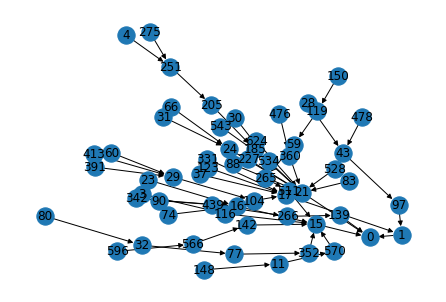

In [13]:
MIA,_,_,_=dijkstra_MIA(0, Graph,True,0.01)
nx.draw(MIA,with_labels=1)
compute_ap_N(0,[0, 4, 1, 2, 3],[],MIA,Graph)

In [14]:
def find_dc(G,S_P,v):
    visited=[]
    queue=[] 
    queue.append((v,0))
    visited.append(v)
    while queue:
        s = queue.pop(0) 
        if s[0] in S_P:
            return s[1]
        for neighbour in G.successors(s[0]):
            if neighbour not in visited:
                if neighbour in S_P:
                    return s[1]+1
                visited.append(neighbour)
                queue.append((neighbour,s[1]+1))
    return sys.maxsize

In [15]:
def path_blocked(from_node,to_node, MIIA, S):
    current_node=from_node
    if current_node in S:
        return True
    while current_node != to_node:
        if list(MIIA.successors(current_node))[0] in S:
            return True
        else:
            current_node=list(MIIA.successors(current_node))[0] 
    return False

In [16]:
def CMIA_O(G,S_N,k,min_prob): # for this algo we assume the prob of possitive diffusion is 1
    S_P=[]
    Neg_range=set()
    DecInf={}
    dist={}
    D={} # dict to keep track of the distances values per node, and avoid reconstructing MIA
    D_max=[0]*len(G.nodes()) # dict to keep track of the dmax values per node
    MIA_prev_nodes={}# to keep track of the MIIAs without having to reconstruct
    
    start = timeit.default_timer()

    for u in S_N:
        MIOA,_,_,_=dijkstra_MIA(u, G, False, min_prob)
        for v in list(set(MIOA.nodes()) - set(S_N)- set(Neg_range)):
            Neg_range.add(v) # contains the nodes that could get infected      
    for u in Neg_range:
        
        MIIA,shortest_path,previous_nodes,probabilities=dijkstra_MIA(u, G, True, min_prob)
        
        MIA_prev_nodes[u]= [(key,val) for key, val in previous_nodes.items()] #skeleton of MIIA
        ap=compute_ap_N(u,S_N, S_P, MIIA ,G)
        
        for v in list(MIIA.nodes()):
            if  path_blocked(v,u, MIIA, S_N):
                continue
            prov_S_P= S_P + [v]
            ap_v= compute_ap_N(u,S_N, prov_S_P, MIIA ,G) 
            #print(ap_v)
            if v in DecInf:
                DecInf[v]+=(ap-ap_v)
            else:
                DecInf[v]=(ap-ap_v) #compute total impact of the node as truth campaigner 
    
    stop2 = timeit.default_timer()
    #print('Time: ', stop2 - start)       
    for i in range(k): 
        candidates={k:v for k,v in DecInf.items() if k not in S_N+list(S_P)}
        u = max(candidates,key=candidates.get) # chose node with higest impact
        
        MIOA,_,_,_=dijkstra_MIA(u, G, False, min_prob)
        for v in list(MIOA.nodes()): # nodes that u could potentially save
            if v not in Neg_range:
                continue
                
            MIIA.clear()
            nodes={t[0] for t in MIA_prev_nodes[v]}
            nodes.add(v)
            MIIA.add_nodes_from(list(nodes))
            MIIA.add_edges_from(MIA_prev_nodes[v])
            
            for w in list(MIIA.nodes()): #nodes whose contribution now decreses since u helps
                prov_S_P= S_P + [w]
                #print("porv " +str(prov_S_P))
                ap=compute_ap_N(v,S_N,S_P,MIIA ,G)
                #print(ap)
                ap_w=compute_ap_N(v,S_N, prov_S_P, MIIA ,G) 
                #print(ap_w)    
                if w in DecInf: 
                    DecInf[w]-=(ap-ap_w) #remove all influence of w when u was not in S_P  
        
        S_P.append(u) 
        for v in list(set(list(MIOA.nodes())) - set([u])):
            if v not in Neg_range:
                continue
            
            MIIA.clear()
            nodes={t[0] for t in MIA_prev_nodes[v]}
            nodes.add(v)
            MIIA.add_nodes_from(list(nodes))
            MIIA.add_edges_from(MIA_prev_nodes[v])

            ap=compute_ap_N(v,S_N,S_P,MIIA,G)
            for w in list(MIIA.nodes()):
                ap_w=compute_ap_N(v,S_N,prov_S_P,MIIA ,G)
                if w in DecInf:
                        DecInf[w]+=(ap-ap_w)
                    
    stop = timeit.default_timer()
    print('Time: ', stop - start)          
                    
    return S_P 
k_n=5 
network=Graph
S_N=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]
print(S_N)
print(CMIA_O(network,S_N,5,0.01))    

[3, 1, 21, 4, 11]
Time:  79.8763734
[150, 48, 57, 339, 398]


In [17]:
def get_communities(part,G):
    communities = []
    for i in G.nodes():
        if part[i] not in communities:
            communities.append(part[i])
    return len(communities)

In [19]:
# here we want to max the help of the least helped community
# where help is the expected number of saved nodes in the community
set_background('honeydew') # to avoid confusion with previous cell
def CMIA_O_fair_new(G,S_N,k,min_prob,partition): # for this algo we assume the prob of possitive diffusion is 1
    start = timeit.default_timer()
    communities=get_communities(partition,G)
    DecInf_needed={}
    E_inf_num=[0]*communities
    E_current=[0]*communities
    pop_communities=[0]*communities
    saved_per_comm=[0]*communities
    for c in range(communities):
        pop_communities[c]=[v for k,v in partition.items()].count(c)
           
    #print(pop_communities)    
    S_P=[]
    Neg_range=set()
    E_inf_comm_v={}
    MIA_prev_nodes={}# to keep track of the MIIAs without having to reconstruct
    
   

    for u in S_N:
        MIOA,_,_,_=dijkstra_MIA(u, G, False, min_prob)
        for v in list(set(MIOA.nodes()) - set(S_N)- set(Neg_range)):
            Neg_range.add(v) # contains the nodes that could get infected
    #print(Neg_range)        
    for u in Neg_range:
        MIIA,shortest_path,previous_nodes,probabilities=dijkstra_MIA(u, G, True, min_prob)
        MIA_prev_nodes[u]= [(key,val) for key, val in previous_nodes.items()] #skeleton of MIIA
        
        ap=compute_ap_N(u,S_N, S_P, MIIA ,G)
        E_current[partition[u]]+=ap
        E_inf_num[partition[u]]+=ap
        
        for v in list(MIIA.nodes()):
            if  path_blocked(v,u, MIIA, S_N):
                continue
            prov_S_P= S_P + [v]
            ap_v= compute_ap_N(u,S_N, prov_S_P, MIIA ,G) 
            if v in E_inf_comm_v:
                E_inf_comm_v[v][partition[u]]+= (ap-ap_v)
            else:
                E_inf_comm_v[v]=[0]*communities
                E_inf_comm_v[v][partition[u]]= (ap-ap_v) #compute total impact of the node as truth campaigner 
                
    for i in range(k): 
        #print(str(i)+"/"+str(k))
        start_k = timeit.default_timer()
        #print("so far we have saved:"+str([float(saved_per_comm[c]/E_inf_num[c]) if E_inf_num[c]!=0 else 1 for c in range(communities)])) 
        
        if not S_P: # in the first round we choose the node with the biggest contribution
            DecInf={v:sum(E_inf_comm_v[v]) for v in E_inf_comm_v} 
            candidates={k:v for k,v in DecInf.items() if k not in S_N+list(S_P)}
        else:
            need_saving=[c for c in range(communities) if saved_per_comm[c]==min(saved_per_comm)]
            #print("we still need to save communities:"+ str(need_saving))
            
            DecInf_needed={v:sum([E_inf_comm_v[v][c] for c in need_saving ]) for v in E_inf_comm_v}
            #print(DecInf_needed)
            
            prob_per_com_v={}
            resulting_help_v={}
            for key in E_inf_comm_v.keys():
                prob_per_com_v[key]=[float((saved_per_comm[c]+E_inf_comm_v[key][c])/E_inf_num[c]) if E_inf_num[c]!=0 else 1 for c in range(communities)]
                
            candidates={k:min(v) for k,v in prob_per_com_v.items() if k not in S_N+list(S_P)}
            candidates=dict(sorted(candidates.items(), key=lambda kv: DecInf_needed[kv[0]], reverse=True))
            #print(candidates)
            
         
        u = max(candidates,key=candidates.get) # chose node with higest impact
        #print("u "+str(u))
        stop_k = timeit.default_timer()
        #print('Time: ', stop_k - start_k)
        start2 = timeit.default_timer()
        #print([float(E_inf_comm_v[u][c]/E_inf_num[c]) if E_inf_num[c] else 1 for c in range(communities)])
        #print()
        saved_per_comm=[E_inf_comm_v[u][c]+saved_per_comm[c] for c in range(communities)]
        
        MIOA,_,_,_=dijkstra_MIA(u, G, False, min_prob)
        for v in list(MIOA.nodes()): # nodes that u could potentially save
            if v not in Neg_range:
                continue
                
            MIIA.clear()
            nodes={t[0] for t in MIA_prev_nodes[v]}
            nodes.add(v)
            MIIA.add_nodes_from(list(nodes))
            MIIA.add_edges_from(MIA_prev_nodes[v])
            
            ap=compute_ap_N(v,S_N,S_P,MIIA ,G)
            ap_u=compute_ap_N(v,S_N,S_P+[u],MIIA,G)
            E_current[partition[v]]-=ap
            
            for w in list(MIIA.nodes()): #nodes whose contribution now decreses since u helps
                if  path_blocked(w,v, MIIA, S_N):continue
                if E_inf_comm_v[w][partition[v]]!=0:
                    prov_S_P= S_P + [w]
                    ap_w=compute_ap_N(v,S_N, prov_S_P, MIIA ,G) 
                    if w in E_inf_comm_v: 
                        E_inf_comm_v[w][partition[v]]-=(ap-ap_w) #remove all influence of w when u was not in S_P  
                    if w!=u:    
                        ap_u_w=compute_ap_N(v,S_N,prov_S_P+[u],MIIA ,G)
                        if w in E_inf_comm_v:
                                E_inf_comm_v[w][partition[v]]+=(ap_u-ap_u_w)
                    
                    
        S_P.append(u)
        stop2 = timeit.default_timer()
        #print('Time: ', stop2 - start2)
    #print(min([float(saved_per_comm[c]/E_inf_num[c]) if E_inf_num[c]!=0 else 1 for c in range(communities)]))                  
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    #print("last we expect" + str([float(E_current[c]/pop_communities[c])  for c in range(communities)]))    
    return S_P 

k_n=5
network=Graph
S_N=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]
print(S_N)
partition = community_louvain.best_partition(network.to_undirected(reciprocal=False, as_view=False), random_state=10)
print(CMIA_O_fair_new(network,S_N,3,0.01,partition))   

[3, 1, 21, 4, 11]
Time:  45.2255423
[150, 47, 66]


In [23]:
# here we want to max the help of the least helped community
# where help is the expected number of saved nodes in the community
set_background('lightcyan') # to avoid confusion with previous cell
def CMIA_O_fair_per(G,S_N,k,min_prob,partition): # for this algo we assume the prob of possitive diffusion is 1
    start = timeit.default_timer()
    communities=get_communities(partition,G)
    DecInf_needed={}
    E_inf_num=[0]*communities
    E_current=[0]*communities
    pop_communities=[0]*communities
    
    for c in range(communities):
        pop_communities[c]=[v for k,v in partition.items()].count(c)
           
    #print(pop_communities)    
    S_P=[]
    Neg_range=set()
    E_inf_comm_v={}
    MIA_prev_nodes={}# to keep track of the MIIAs without having to reconstruct
    
   

    for u in S_N:
        MIOA,_,_,_=dijkstra_MIA(u, G, False, min_prob)
        for v in list(set(MIOA.nodes()) - set(S_N)- set(Neg_range)):
            Neg_range.add(v) # contains the nodes that could get infected
    #print(Neg_range)        
    for u in Neg_range:
        MIIA,shortest_path,previous_nodes,probabilities=dijkstra_MIA(u, G, True, min_prob)
        MIA_prev_nodes[u]= [(key,val) for key, val in previous_nodes.items()] #skeleton of MIIA
        
        ap=compute_ap_N(u,S_N, S_P, MIIA ,G)
        E_current[partition[u]]+=ap
        E_inf_num[partition[u]]+=ap
        
        for v in list(MIIA.nodes()):
            if  path_blocked(v,u, MIIA, S_N):
                continue
            prov_S_P= S_P + [v]
            ap_v= compute_ap_N(u,S_N, prov_S_P, MIIA ,G) 
            if v in E_inf_comm_v:
                E_inf_comm_v[v][partition[u]]+= (ap-ap_v)
            else:
                E_inf_comm_v[v]=[0]*communities
                E_inf_comm_v[v][partition[u]]= (ap-ap_v) #compute total impact of the node as truth campaigner 
                
    Inf_per_comm=[E_inf_num[c] for c in range(communities)]          
    for i in range(k): 
        #print(str(i)+"/"+str(k))
        start_k = timeit.default_timer()
        #print("so far health is:"+str([float((pop_communities[c]-Inf_per_comm[c])/pop_communities[c]) for c in range(communities)])) 
        
        if not S_P: # in the first round we choose the node with the biggest contribution
            DecInf={v:sum(E_inf_comm_v[v]) for v in E_inf_comm_v} 
            candidates={k:v for k,v in DecInf.items() if k not in S_N+list(S_P)}
        else:
            health_per_comm=[(pop_communities[c]-Inf_per_comm[c])/pop_communities[c] for c in range(communities)]
            need_saving=[c for c in range(communities) if health_per_comm[c]==min(health_per_comm)]
            #print("we still need to save communities:"+ str(need_saving))
            
            DecInf_needed={v:sum([E_inf_comm_v[v][c] for c in need_saving]) for v in E_inf_comm_v}
            #print(DecInf_needed)
            
            prob_per_com_v={}
            resulting_help_v={}
            for key in E_inf_comm_v.keys():
                prob_per_com_v[key]=[float((pop_communities[c]-E_inf_num[c]+E_inf_comm_v[key][c])/pop_communities[c])for c in range(communities)]
                
            candidates={k:min(v) for k,v in prob_per_com_v.items() if k not in S_N+list(S_P)}
            candidates=dict(sorted(candidates.items(), key=lambda kv: DecInf_needed[kv[0]], reverse=True))
            #print(candidates)
            
         
        u = max(candidates,key=candidates.get) # chose node with higest impact
        #print("u "+str(u))
        stop_k = timeit.default_timer()
        #print('Time: ', stop_k - start_k)
        start2 = timeit.default_timer()
        #print([float(E_inf_comm_v[u][c]/E_inf_num[c]) if E_inf_num[c] else 1 for c in range(communities)])
        #print()
        Inf_per_comm=[E_inf_num[c]-E_inf_comm_v[u][c] for c in range(communities)]
        
        MIOA,_,_,_=dijkstra_MIA(u, G, False, min_prob)
        for v in list(MIOA.nodes()): # nodes that u could potentially save
            if v not in Neg_range:
                continue
                
            MIIA.clear()
            nodes={t[0] for t in MIA_prev_nodes[v]}
            nodes.add(v)
            MIIA.add_nodes_from(list(nodes))
            MIIA.add_edges_from(MIA_prev_nodes[v])
            
            ap=compute_ap_N(v,S_N,S_P,MIIA ,G)
            ap_u=compute_ap_N(v,S_N,S_P+[u],MIIA,G)
            E_current[partition[v]]-=ap
            
            for w in list(MIIA.nodes()): #nodes whose contribution now decreses since u helps
                if  path_blocked(w,v, MIIA, S_N):continue
                if E_inf_comm_v[w][partition[v]]!=0:
                    prov_S_P= S_P + [w]
                    ap_w=compute_ap_N(v,S_N, prov_S_P, MIIA ,G) 
                    if w in E_inf_comm_v: 
                        E_inf_comm_v[w][partition[v]]-=(ap-ap_w) #remove all influence of w when u was not in S_P  
                    if w!=u:    
                        ap_u_w=compute_ap_N(v,S_N,prov_S_P+[u],MIIA ,G)
                        if w in E_inf_comm_v:
                                E_inf_comm_v[w][partition[v]]+=(ap_u-ap_u_w)
                    
                    
        S_P.append(u)
        stop2 = timeit.default_timer()
        #print('Time: ', stop2 - start2)
    #print(min([float(saved_per_comm[c]/E_inf_num[c]) if E_inf_num[c]!=0 else 1 for c in range(communities)]))                  
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    #print("last we expect" + str([float(E_current[c]/pop_communities[c])  for c in range(communities)]))    
    return S_P 

k_n=5
network=Graph
S_N=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]
print(S_N)
partition = community_louvain.best_partition(network.to_undirected(reciprocal=False, as_view=False), random_state=10)
print(CMIA_O_fair_per(network,S_N,5,0.01,partition))   

[3, 1, 21, 4, 11]
Time:  25.350363600000037
[150, 66, 220, 338, 343]


In [21]:
#functions used in the MCICM simulation
def set_all_Neu(G): # function to seet all nodes to neutral
    for i in G.nodes():
        G.nodes[i]['action'] = 'Neu'
    return G   

def set_Neg(G, list1): # function to set nodes in the negative seed to negative and active (Neg_a)
    for i in list1:
        G.nodes[i]['action'] = 'Neg_a'
    return G   

def set_Pos(G, list1): # function to set nodes in the positive seed to positive and active (Pos_a)
    for i in list1:
        G.nodes[i]['action'] = 'Pos_a'
    return G 

def get_colors(G): #functions to translate state to color for visualization
    color = []
    for i in G.nodes():
        if (G.nodes[i]['action'] == 'Neg' or G.nodes[i]['action'] == 'Neg_a'):
            color.append('red')
        elif (G.nodes[i]['action'] == 'Pos'or G.nodes[i]['action'] == 'Pos_a'):
            color.append('green')
        else:
            color.append('blue')
    return color

def recalculate(G,negative,positive): # function to update the state of each node after a step
    dict1 = {}
    
    for i in positive: # the positive nodes have preference
        neigh = G.neighbors(i)
        for j in neigh:
            if (G.nodes[j]['action'] == 'Neu' and random.uniform(0, 1)<=(1/G.in_degree(j))): # if node has no opinion yet 
                G.nodes[j]['action'] = 'Pos_a'
                positive.append(j)
        G.nodes[i]['action'] = 'Pos' # and the node is no longer active
        positive.remove(i)
        
    for i in negative:
        neigh = G.neighbors(i)
        for j in neigh:
            if (G.nodes[j]['action'] == 'Neu' and random.uniform(0, 1)<=(1/G.in_degree(j))):
                G.nodes[j]['action'] = 'Neg_a'
                negative.append(j)
        G.nodes[i]['action'] = 'Neg' # and the node is no longer active
        negative.remove(i)
    return G,positive,negative
                
def Calculate(G,n,S_N,S_P): # function that given a graph G with nodes in different states runs a MCICM for n iterations
    pos,neg=S_P.copy(),S_N.copy()
    keep_going = True
    count = 0
    while (keep_going):
        count += 1
        G,pos,neg=recalculate(G,neg,pos)
        if not neg: # if no new nodes are infected  
            keep_going = False 
    return G

668
[3, 1, 21, 4, 11]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 63.29it/s]


[27, 4, 16, 5, 8, 5, 8, 11, 6, 3, 2, 5, 3, 2, 8, 13, 2, 12, 4, 11]
Time:  105.51698609999994
Time:  95.17513819999999


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

buget is 1


 10%|████████▎                                                                          | 1/10 [00:04<00:42,  4.74s/it]

buget is 4


 20%|████████████████▌                                                                  | 2/10 [00:09<00:36,  4.57s/it]

buget is 7


 30%|████████████████████████▉                                                          | 3/10 [00:13<00:31,  4.48s/it]

buget is 10


 40%|█████████████████████████████████▏                                                 | 4/10 [00:17<00:26,  4.45s/it]

buget is 13


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:21<00:21,  4.29s/it]

buget is 17


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:26<00:17,  4.40s/it]

buget is 20


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:30<00:12,  4.23s/it]

buget is 23


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:34<00:08,  4.29s/it]

buget is 26


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:41<00:04,  4.99s/it]

buget is 30


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.70s/it]
C:\Users\usuario\AppData\Local\Temp/ipykernel_19488/4173314987.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values, CMIA_fair_results_t, '--bo', label='CMIA fair alternative',color='green')
C:\Users\usuario\AppData\Local\Temp/ipykernel_19488/4173314987.py:107: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values, CMIA_results_t, '--bo', label='CMIA',color='red')
C:\Users\usuario\AppData\Local\Temp/ipykernel_19488/4173314987.py:111: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values, CMI

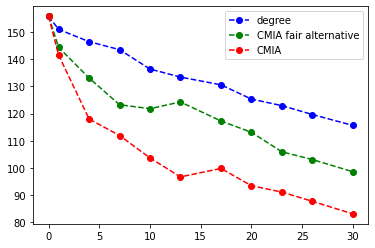

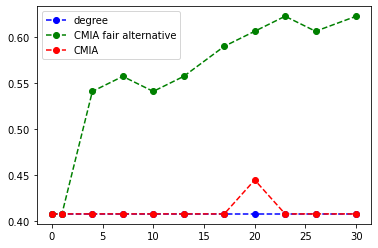

Time:  250.08194500000002


In [25]:
def MCICM(G,S_N,S_P,base):
    start1 = timeit.default_timer()
    G1 = G.copy()
    G1=set_Pos(set_Neg(set_all_Neu(G1),S_N),S_P)
    G1=Calculate(G1,100,S_N,S_P)
    stop2 = timeit.default_timer()
    #print('Time: ', stop2 - start1)
    colors = get_colors(G1)
    communities=get_communities(partition,G)
    infection_comm=[0]*communities    
    
        
    for i in list(set(G.nodes())-set(S_N)):
        if colors[i]=='red':  
            infection_comm[partition[i]]+=1 
            
    total=sum(infection_comm) 
    stop1 = timeit.default_timer()
    #print('Time: ', stop1 - start1)
    return total,infection_comm

start = timeit.default_timer()
network=Graph
partition = community_louvain.best_partition(network.to_undirected(reciprocal=False, as_view=False), random_state=10)
num_com= get_communities(partition,network)

pop_communities=[0]*num_com    
for c in range(num_com):
    pop_communities[c]=[v for k,v in partition.items()].count(c)
print(len(network.nodes()))
k_n=5
k_p=30
S_N=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]
print(S_N)
iterations=100
degrees=sorted(network.out_degree, key=lambda x: x[1], reverse=True)
candidates_deg= list(set([t[0] for t in degrees])-set(S_N))
base=[]
base_total=[]
for node in tqdm(range(iterations)):
    total,infection_comm=MCICM(network,S_N,[],[])
    base.append(infection_comm)
    base_total.append(total)
base=[round(np.mean(base, axis=0)[c]) for c in range(num_com)]
print(base)

CMIA_results_t,CMIA_fair_results_t,degree_results_t=[np.mean(base_total)],[np.mean(base_total)],[np.mean(base_total)]
#print(CMIA_results_t,CMIA_fair_results_t,degree_results_t)
value=min([(pop_communities[c]-base[c])/pop_communities[c] for c in range(num_com)])
CMIA_results_f,CMIA_fair_results_f,degree_results_f=[value],[value],[value]

number_values=10

candidates_cmia=CMIA_O(network,S_N,k_p,0.01)
candidates_fair=CMIA_O_fair_per(network,S_N,k_p,0.01,partition)

for i in tqdm(np.linspace(1, k_p, num=number_values,dtype=int)): 
    k_p=i.copy()
    print("buget is "+str(k_p))
    CMIA,CMIA_fair,degree=[],[],[]
    CMIA_t,CMIA_fair_t,degree_t=[],[],[]

    S_P=candidates_cmia[0:k_p]
    S_P_fair=candidates_fair[0:k_p]

    S_P_2= candidates_deg[0:k_p]

    CMIA_f,CMIA_fair_f,degree_f=[],[],[]
    for iter in tqdm(range(iterations), position=0, leave=True):
        total,infection_comm =MCICM(network,S_N,S_P_fair,base)
        CMIA_fair_f.append(infection_comm)
        CMIA_fair_t.append(total)

        total,infection_comm=MCICM(network,S_N,S_P,base)
        CMIA_f.append(infection_comm)
        CMIA_t.append(total)

        total,infection_comm=MCICM(network,S_N,S_P_2,base)
        degree_f.append(infection_comm)
        degree_t.append(total)
        
        #print(CMIA_fair_t,CMIA_t,degree_t)
    #for c in [x for x in range(num_com) if base[x]!=0]:
        #print("we expected"+str(base[c]))
        #print(round(np.mean(CMIA_fair_f,axis=0)[c]),round(np.mean(CMIA_f,axis=0)[c]),round(np.mean(degree_f,axis=0)[c]))
        #print(max((base[c]-round(np.mean(CMIA_fair_f,axis=0)[c]))/base[c],0),max((base[c]-round(np.mean(CMIA_f,axis=0)[c]))/base[c],0),max((base[c]-round(np.mean(degree_f,axis=0)[c]))/base[c],0))
        
    degree_results_t.append(np.mean(degree_t))
    degree_results_f.append(np.min([max((pop_communities[c]-round(np.mean(degree_f,axis=0)[c]))/pop_communities[c],0) for c in range(num_com)]))
    
    CMIA_results_t.append(np.mean(CMIA_t))
    CMIA_results_f.append(np.min([max((pop_communities[c]-round(np.mean(CMIA_f,axis=0)[c]))/pop_communities[c],0) for c in range(num_com)]))
    
    CMIA_fair_results_t.append(np.mean(CMIA_fair_t))
    CMIA_fair_results_f.append(np.min([max((pop_communities[c]-round(np.mean(CMIA_fair_f,axis=0)[c]))/pop_communities[c],0) for c in range(num_com)]))
    
    #for c in [x for x in range(num_com) if base[x]!=0]:
         #print(CMIA_fair_results_f,CMIA_results_f,degree_results_f)
    #print("average of iterations")
    #print(CMIA_fair_results_f,CMIA_results_f,degree_results_f)
    #print(np.mean(CMIA_fair_f,axis=0),np.mean(CMIA_f,axis=0),np.mean(degree_f,axis=0))
x_values=[0]
x_values.extend(np.linspace(1, k_p, num=number_values,dtype=int))
plt.figure(1)
plt.plot(x_values,degree_results_t, '--bo', label='degree')
plt.plot(x_values, CMIA_fair_results_t, '--bo', label='CMIA fair alternative',color='green')
plt.plot(x_values, CMIA_results_t, '--bo', label='CMIA',color='red')
plt.legend()
plt.figure(2)
plt.plot(x_values, degree_results_f, '--bo', label='degree')
plt.plot(x_values, CMIA_fair_results_f, '--bo', label='CMIA fair alternative',color='green')
plt.plot(x_values, CMIA_results_f, '--bo', label='CMIA',color='red')
plt.legend()
plt.show()
stop = timeit.default_timer()
print('Time: ', stop - start)